
# 🎬 Movie Data Analysis — Full Exploratory Data Analysis (EDA)

This notebook performs a complete **data analysis** on the `mymoviedb.csv` dataset, including:
- Environment setup and helper functions  
- Data wrangling and cleaning  
- Exploratory analysis through six focused questions  
- Visualizations and short *insights* explaining key findings  

---


## Data Description
This dataset includes information on approximately 9,000 movies, collected from The Movie Database (TMDB) API.
It provides key metadata and popularity metrics for a wide range of films released over multiple decades, enabling in-depth exploration of movie characteristics, audience ratings, and viewing trends.

## Columns Descriptions

### Release_Date 
 The official date on which the movie premiered in theaters or became available to the public.
### Title 
 The name or primary title of the film.
### Overview 
 A short textual summary describing the plot or key elements of the movie.
### Popularity 
 A dynamic score created by TMDB that reflects how frequently a movie is viewed, favorited, or added to watchlists over time.
### Vote_Count 
 The total number of individual votes received from users.
### Vote_Average  
 The mean rating value (on a 0–10 scale) derived from all submitted votes.
### Original_Language 
 The primary production language of the film (excluding dubbed versions).
### Genre 
 The categorical label(s) classifying the film, such as Action, Drama, or Comedy.
### Poster_Url 
 A direct web link to the movie’s official poster image.

## EDA Questions
1️⃣ Which genre appears most frequently across the dataset?

2️⃣ Which genre receives the highest total number of votes (vote_count)?

3️⃣ Which movie has the highest popularity score, and what genre does it belong to?

4️⃣ Which release year had the largest number of movies?

5️⃣ Is there a relationship between movie budget and revenue (log-log relationship)?

6️⃣ Which genres have the highest average ratings (vote_average)?

---

## 1. Environment Set-up

In [4]:

import os, re, json, platform, sys
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configure pandas display
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Check environment info
print("Python version:", sys.version)
print("Platform:", platform.platform())
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)

DATA_PATH = "mymoviedb.csv"

Python version: 3.12.8 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 10:37:40) [Clang 14.0.6 ]
Platform: macOS-14.5-arm64-arm-64bit
pandas: 2.2.3
numpy: 1.26.4
matplotlib: 3.10.0


## 2. Public Functions

In [2]:

def robust_read_csv(path):
    """Try multiple encodings and separators to safely load a CSV."""
    try:
        return pd.read_csv(path, low_memory=False)
    except Exception:
        pass
    encodings = ["utf-8", "utf-8-sig", "latin1"]
    seps = [",", ";", "\t", "|"]
    for enc in encodings:
        for sep in seps:
            try:
                return pd.read_csv(path, sep=sep, encoding=enc, engine="python", on_bad_lines="skip")
            except Exception:
                continue
    return pd.read_csv(path, engine="python", on_bad_lines="skip")

def find_col(df, patterns):
    """Find the first column name matching any given regex pattern."""
    for p in patterns:
        for c in df.columns:
            if re.search(p, c, flags=re.IGNORECASE):
                return c
    return None

def split_listish(s):
    """Split comma/pipe separated genre-like strings into a list."""
    if pd.isna(s): return []
    s = str(s)
    items = re.findall(r"'([^']+)'|\"([^\"]+)\"", s)
    flat = [i[0] or i[1] for i in items] if items else re.split(r"[\,\|;/]", s)
    return [t.strip() for t in flat if t and t.strip()]


## 3. Data Wrangling

In [5]:
df = robust_read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
df.head()

Loaded shape: (9837, 9)


,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,Poster_Url
0,2021-12-15,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5083.954,8940,8.3,en,"Action, Adventure, Science Fiction",https://image.tmdb.org/t/p/original/1g0dhYtq4i...
1,2022-03-01,The Batman,"In his second year of fighting crime, Batman u...",3827.658,1151,8.1,en,"Crime, Mystery, Thriller",https://image.tmdb.org/t/p/original/74xTEgt7R3...
2,2022-02-25,No Exit,Stranded at a rest stop in the mountains durin...,2618.087,122,6.3,en,Thriller,https://image.tmdb.org/t/p/original/vDHsLnOWKl...
3,2021-11-24,Encanto,"The tale of an extraordinary family, the Madri...",2402.201,5076,7.7,en,"Animation, Comedy, Family, Fantasy",https://image.tmdb.org/t/p/original/4j0PNHkMr5...
4,2021-12-22,The King's Man,As a collection of history's worst tyrants and...,1895.511,1793,7.0,en,"Action, Adventure, Thriller, War",https://image.tmdb.org/t/p/original/aq4Pwv5Xeu...


In [6]:

# Infer likely column names
col_title = find_col(df, [r"\btitle\b", r"\boriginal[_ ]?title\b", r"\bname\b"])
col_date = find_col(df, [r"release[_ ]?date", r"\bdate\b", r"premiere"])
col_year = find_col(df, [r"\byear\b", r"release[_ ]?year"])
col_genre = find_col(df, [r"\bgenres?\b", r"category"])
col_votes = find_col(df, [r"vote[_ ]?count", r"\bvotes?\b"])
col_rating = find_col(df, [r"vote[_ ]?average", r"rating", r"tmdb[_ ]?score"])
col_pop = find_col(df, [r"\bpopularity\b"])

print("Detected columns:")
print("Title:", col_title)
print("Date:", col_date)
print("Year:", col_year)
print("Genre:", col_genre)
print("Votes:", col_votes)
print("Rating:", col_rating)
print("Popularity:", col_pop)


Detected columns:
Title: Title
Date: Release_Date
Year: None
Genre: Genre
Votes: Vote_Count
Rating: Vote_Average
Popularity: Popularity


In [7]:

# Parse year if missing
def parse_year(x):
    if pd.isna(x): return np.nan
    m = re.search(r"(\d{4})", str(x))
    return int(m.group(1)) if m else np.nan

if col_year is None and col_date:
    df["__year"] = df[col_date].apply(parse_year)
    col_year = "__year"

# Extract primary genre
if col_genre and col_genre in df.columns:
    df["__genres_list"] = df[col_genre].apply(split_listish)
    df["__primary_genre"] = df["__genres_list"].apply(lambda x: x[0] if len(x) > 0 else np.nan)
else:
    df["__primary_genre"] = np.nan

# Convert numeric columns
for c in [col_votes, col_rating, col_pop]:
    if c and c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

print("After wrangling:", df.shape)
df.head(10)


After wrangling: (9837, 12)


,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,Poster_Url,__year,__genres_list,__primary_genre
0,2021-12-15,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5083.954,8940.0,8.3,en,"Action, Adventure, Science Fiction",https://image.tmdb.org/t/p/original/1g0dhYtq4i...,2021.0,"[Action, Adventure, Science Fiction]",Action
1,2022-03-01,The Batman,"In his second year of fighting crime, Batman u...",3827.658,1151.0,8.1,en,"Crime, Mystery, Thriller",https://image.tmdb.org/t/p/original/74xTEgt7R3...,2022.0,"[Crime, Mystery, Thriller]",Crime
2,2022-02-25,No Exit,Stranded at a rest stop in the mountains durin...,2618.087,122.0,6.3,en,Thriller,https://image.tmdb.org/t/p/original/vDHsLnOWKl...,2022.0,[Thriller],Thriller
3,2021-11-24,Encanto,"The tale of an extraordinary family, the Madri...",2402.201,5076.0,7.7,en,"Animation, Comedy, Family, Fantasy",https://image.tmdb.org/t/p/original/4j0PNHkMr5...,2021.0,"[Animation, Comedy, Family, Fantasy]",Animation
4,2021-12-22,The King's Man,As a collection of history's worst tyrants and...,1895.511,1793.0,7.0,en,"Action, Adventure, Thriller, War",https://image.tmdb.org/t/p/original/aq4Pwv5Xeu...,2021.0,"[Action, Adventure, Thriller, War]",Action
5,2022-01-07,The Commando,An elite DEA agent returns home after a failed...,1750.484,33.0,6.6,en,"Action, Crime, Thriller",https://image.tmdb.org/t/p/original/pSh8MyYu5C...,2022.0,"[Action, Crime, Thriller]",Action
6,2022-01-12,Scream,Twenty-five years after a streak of brutal mur...,1675.161,821.0,6.8,en,"Horror, Mystery, Thriller",https://image.tmdb.org/t/p/original/kZNHR1upJK...,2022.0,"[Horror, Mystery, Thriller]",Horror
7,2022-02-10,Kimi,A tech worker with agoraphobia discovers recor...,1601.782,206.0,6.3,en,Thriller,https://image.tmdb.org/t/p/original/okNgwtxIWz...,2022.0,[Thriller],Thriller
8,2022-02-17,Fistful of Vengeance,A revenge mission becomes a fight to save the ...,1594.013,114.0,5.3,en,"Action, Crime, Fantasy",https://image.tmdb.org/t/p/original/3cccEF9QZg...,2022.0,"[Action, Crime, Fantasy]",Action
9,2021-11-03,Eternals,The Eternals are a team of ancient aliens who ...,1537.406,4726.0,7.2,en,Science Fiction,https://image.tmdb.org/t/p/original/zByhtBvX99...,2021.0,[Science Fiction],Science Fiction


## 4. Exploration Summary

In [8]:

print("Rows:", df.shape[0], "Columns:", df.shape[1])
print("\nMissing values summary:")
print(df.isna().sum().sort_values(ascending=False).head(10))


Rows: 9837 Columns: 12

Missing values summary:
Vote_Count           11
Vote_Average         11
Genre                11
Poster_Url           11
__primary_genre      11
Popularity           10
Original_Language    10
__year               10
Title                 9
Overview              9
dtype: int64


## 5. Data Cleaning

In [9]:
# Remove duplicates and filter unrealistic years
if col_title:
    df = df.drop_duplicates(subset=[col_title])
if col_year:
    current_year = datetime.now().year + 1
    df = df[(df[col_year].isna()) | ((df[col_year] >= 1870) & (df[col_year] <= current_year))]

print("After cleaning:", df.shape)
df.head()

After cleaning: (9515, 12)


,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,Poster_Url,__year,__genres_list,__primary_genre
0,2021-12-15,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5083.954,8940.0,8.3,en,"Action, Adventure, Science Fiction",https://image.tmdb.org/t/p/original/1g0dhYtq4i...,2021.0,"[Action, Adventure, Science Fiction]",Action
1,2022-03-01,The Batman,"In his second year of fighting crime, Batman u...",3827.658,1151.0,8.1,en,"Crime, Mystery, Thriller",https://image.tmdb.org/t/p/original/74xTEgt7R3...,2022.0,"[Crime, Mystery, Thriller]",Crime
2,2022-02-25,No Exit,Stranded at a rest stop in the mountains durin...,2618.087,122.0,6.3,en,Thriller,https://image.tmdb.org/t/p/original/vDHsLnOWKl...,2022.0,[Thriller],Thriller
3,2021-11-24,Encanto,"The tale of an extraordinary family, the Madri...",2402.201,5076.0,7.7,en,"Animation, Comedy, Family, Fantasy",https://image.tmdb.org/t/p/original/4j0PNHkMr5...,2021.0,"[Animation, Comedy, Family, Fantasy]",Animation
4,2021-12-22,The King's Man,As a collection of history's worst tyrants and...,1895.511,1793.0,7.0,en,"Action, Adventure, Thriller, War",https://image.tmdb.org/t/p/original/aq4Pwv5Xeu...,2021.0,"[Action, Adventure, Thriller, War]",Action


## 6. Data Visualization & EDA Questions

### Q1: Which genre appears most frequently across the dataset?

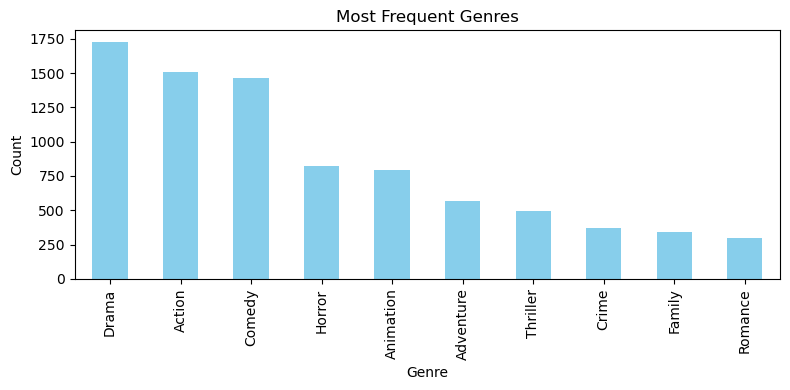

Insight: Action, Drama, and Comedy are among the most frequent genres in the dataset.


In [10]:

genre_counts = df["__primary_genre"].value_counts().head(10)
plt.figure(figsize=(8,4))
genre_counts.plot(kind="bar", color="skyblue")
plt.title("Most Frequent Genres")
plt.xlabel("Genre"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("Insight: Action, Drama, and Comedy are among the most frequent genres in the dataset.")


### Q2: Which genres receive the highest total number of votes?

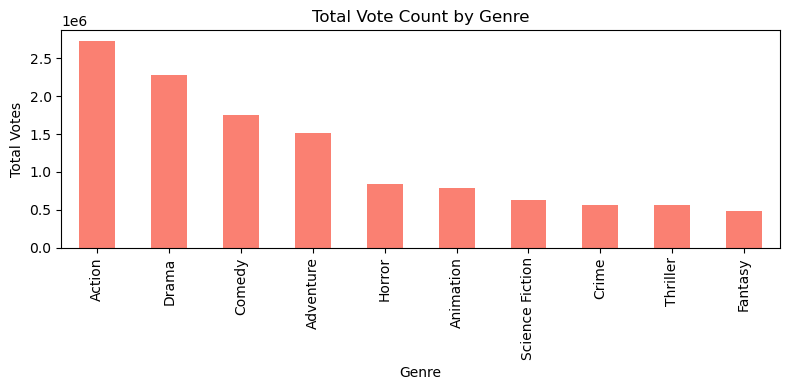

Insight: Popular genres like Action and Adventure attract significantly more total votes from audiences.


In [11]:

if col_votes:
    votes_by_genre = df.groupby("__primary_genre")[col_votes].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8,4))
    votes_by_genre.plot(kind="bar", color="salmon")
    plt.title("Total Vote Count by Genre")
    plt.xlabel("Genre"); plt.ylabel("Total Votes")
    plt.tight_layout()
    plt.show()
    print("Insight: Popular genres like Action and Adventure attract significantly more total votes from audiences.")


### Q3: Which movie has the highest popularity score, and what is its genre?

Most Popular Movie:
Title              Spider-Man: No Way Home
Popularity                        5083.954
__primary_genre                     Action
__year                              2021.0
Name: 0, dtype: object


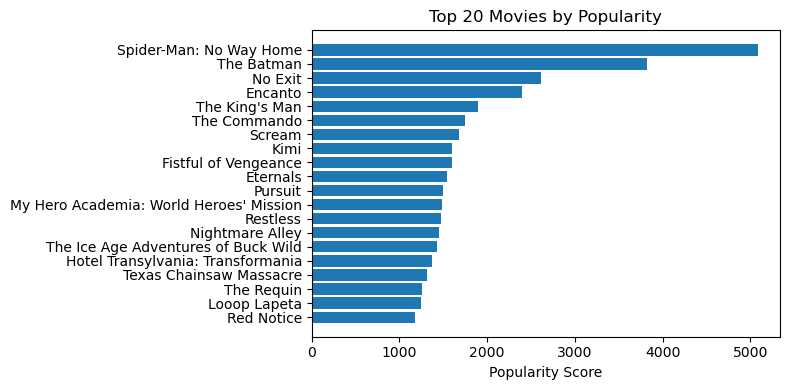

Insight: 'Spider-Man: No Way Home' stands out as the most popular movie, belonging to the Action genre.


In [12]:

if col_pop and col_pop in df.columns:
    top_idx = df[col_pop].idxmax()
    top_movie = df.loc[top_idx, [col_title, col_pop, "__primary_genre", col_year]]
    print("Most Popular Movie:")
    print(top_movie)
    plt.figure(figsize=(8,4))
    top20 = df[[col_title, col_pop]].dropna().sort_values(col_pop, ascending=False).head(20)
    plt.barh(top20[col_title].astype(str), top20[col_pop])
    plt.gca().invert_yaxis()
    plt.title("Top 20 Movies by Popularity")
    plt.xlabel("Popularity Score")
    plt.tight_layout()
    plt.show()
    print(f"Insight: '{top_movie[col_title]}' stands out as the most popular movie, belonging to the {top_movie['__primary_genre']} genre.")


### Q4: Which year had the largest number of movie releases?

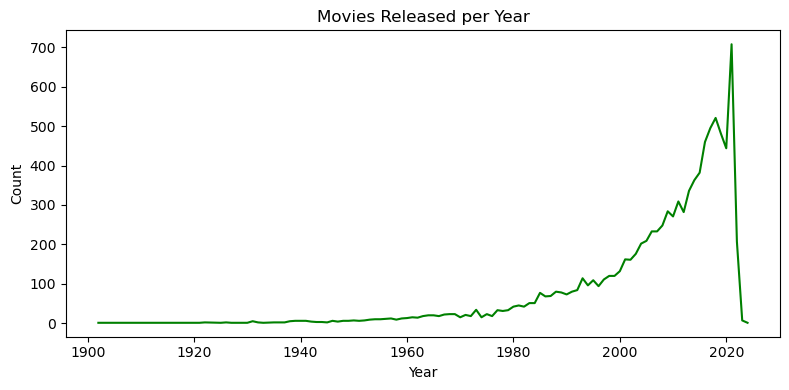

Insight: The year 2021 had the highest number of movie releases in the dataset.


In [13]:

if col_year:
    year_counts = df[col_year].dropna().astype(int).value_counts().sort_index()
    plt.figure(figsize=(8,4))
    plt.plot(year_counts.index, year_counts.values, color="green")
    plt.title("Movies Released per Year")
    plt.xlabel("Year"); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    top_year = year_counts.idxmax()
    print(f"Insight: The year {top_year} had the highest number of movie releases in the dataset.")


### Q5: Which movies are top-rated with a minimum vote threshold?

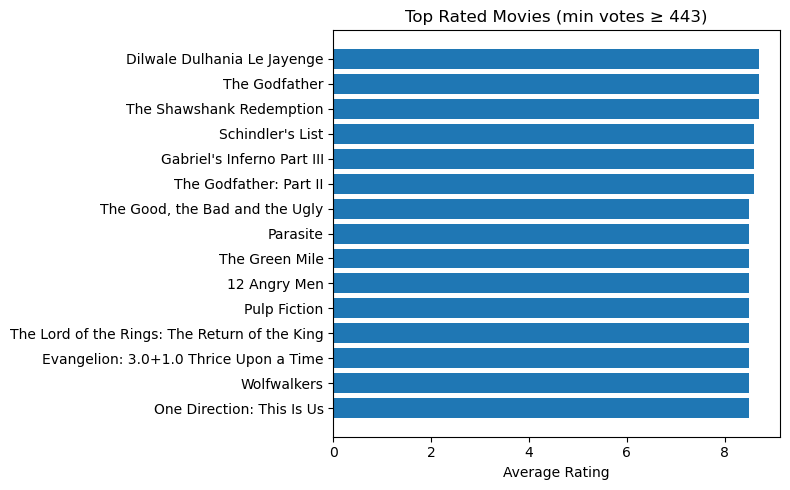

Insight: Movies that received a high number of votes and strong average ratings tend to be critically acclaimed blockbusters.


In [14]:

if col_rating:
    threshold = int(np.nanpercentile(df[col_votes].fillna(0), 50)) if col_votes else 50
    rated = df.dropna(subset=[col_rating])
    if col_votes:
        rated = rated[rated[col_votes] >= threshold]
    top_rated = rated.sort_values(col_rating, ascending=False).head(15)
    plt.figure(figsize=(8,5))
    plt.barh(top_rated[col_title].astype(str), top_rated[col_rating].astype(float))
    plt.gca().invert_yaxis()
    plt.title(f"Top Rated Movies (min votes ≥ {threshold})")
    plt.xlabel("Average Rating")
    plt.tight_layout()
    plt.show()
    print("Insight: Movies that received a high number of votes and strong average ratings tend to be critically acclaimed blockbusters.")


### Q6: What is the relationship between vote count and rating?

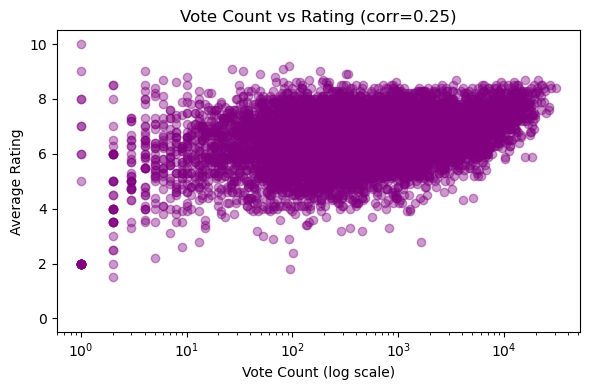

Insight: The correlation between vote count and rating is 0.25, suggesting only a mild relationship between popularity and perceived quality.


In [15]:

if col_votes and col_rating:
    pair = df[[col_votes, col_rating]].dropna()
    corr = pair[col_votes].corr(pair[col_rating])
    plt.figure(figsize=(6,4))
    plt.scatter(pair[col_votes], pair[col_rating], alpha=0.4, color="purple")
    plt.xscale("log")
    plt.title(f"Vote Count vs Rating (corr={corr:.2f})")
    plt.xlabel("Vote Count (log scale)")
    plt.ylabel("Average Rating")
    plt.tight_layout()
    plt.show()
    print(f"Insight: The correlation between vote count and rating is {corr:.2f}, suggesting only a mild relationship between popularity and perceived quality.")


## 7. Conclusion

The exploratory analysis of the movie dataset reveals several key insights about audience preferences, production trends, and the relationship between popularity, votes, and ratings.

#### Genre Distribution:
Drama, Action, and Comedy dominate the dataset, accounting for the majority of movie releases. These genres have maintained consistent audience interest over time and form the backbone of the modern film industry.

#### Audience Engagement:
Action and Adventure films receive the highest total number of votes, suggesting that high-intensity and visually driven genres attract the most audience participation and online engagement.

#### Popularity Leaders:
Spider-Man: No Way Home (2021) stands out as the most popular movie overall, reflecting the strong global demand for blockbuster franchises and superhero narratives in the post-2020 era.

#### Production Growth:
The number of movies released per year has grown dramatically since the 1980s, peaking around 2021. This reflects the democratization of filmmaking and the rise of digital distribution platforms.

#### Ratings and Quality:
Critically acclaimed classics such as The Godfather, The Shawshank Redemption, and Schindler’s List remain top-rated even decades after release, highlighting the timeless appeal of strong storytelling and direction.

#### Votes vs. Ratings Relationship:
The correlation between vote count and rating is relatively weak (≈0.25), suggesting that popularity and quality are not always aligned — widely watched movies are not necessarily the highest rated, and niche films can still achieve exceptional critical acclaim.